# Exploratory Data Analysis

In [377]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from scipy.stats import chi2_contingency

This notebooks focuses on Exploratory Data Analysis, the process of discovering key characteristics of a dataset through statistical visualisations. The main objective is to discover the most appropriate and coherent approach to modelling the data. 

In [378]:
# Importing the preprocessed data:
train = pd.read_pickle('../Data/Preprocessed_1/train_preprocessed_1.pkl')
test = pd.read_pickle('../Data/Preprocessed_1/test_preprocessed_1.pkl')

In [379]:
train.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight Wifi Service',
       'Departure/Arrival Time Convenient', 'Ease of Online Booking',
       'Gate Location', 'Food and Drink', 'Online Boarding', 'Seat Comfort',
       'Inflight Entertainment', 'On-board Service', 'Leg Room Service',
       'Baggage Handling', 'Checkin Service', 'Inflight Service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Satisfaction'],
      dtype='object')

## Pairplot

First, the data's numerical variables are analysied through a pairplot. A pairplot is a grid of scatterplots, depicting the relationship between two numerical features. The plots on the main diagonal represent each feature's distribution. Plot colors will be set to two groups corresponding to the two categories of the response variable. This will provide additional insight into these features' relationship with the response. 

In [380]:
# Select numerical data:
train.select_dtypes('number').head()

,id,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
0,70172,13,460,25,18.0
1,5047,25,235,1,6.0
2,110028,26,1142,0,0.0
3,24026,25,562,11,9.0
4,119299,61,214,0,0.0


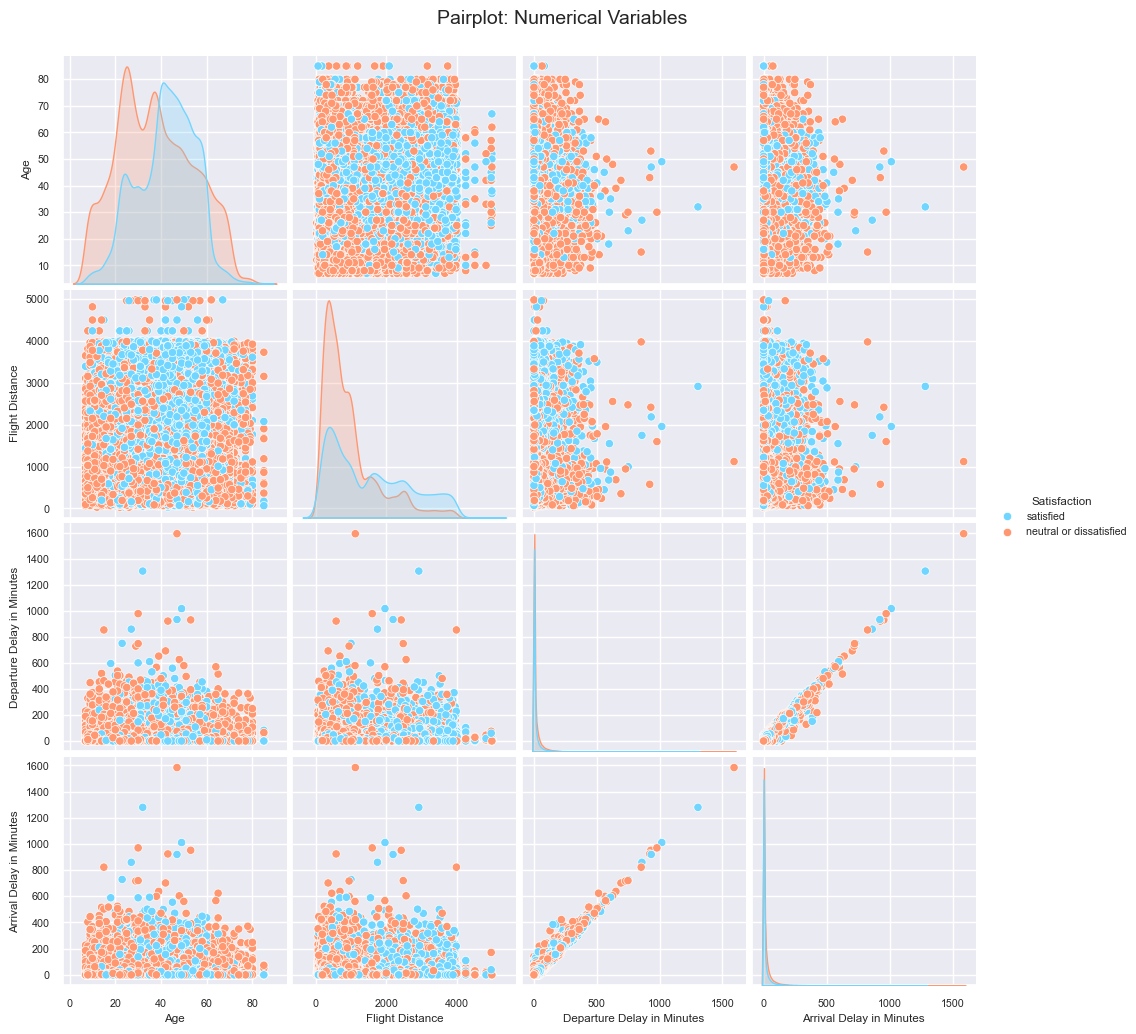

In [381]:
# Plotting the pairsplot with kde for the main diagonal:
hue_colors = {'neutral or dissatisfied': '#FF9770',
              'satisfied': '#70D6FF'}
ax = sns.pairplot(data = train, vars = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'], 
             diag_kind = 'kde', hue = 'Satisfaction', palette = hue_colors)
ax.fig.suptitle('Pairplot: Numerical Variables', fontsize = 14, y = 1.03)
plt.show()

The first subplot (on the main diagonal), shows that a large proportion of satisfied customers are in their middle age. The distribution of this plot resembles a bell-shaped curve. The second subplot on the main diagonal clearly depicts a larger number of passengers going on shorter flights, the distribution is right-skewed. There seem to be slighlty more satisfied customers on longer flights. The other two subplots on the main diagonal simply show that delays (whether on departure of arrival) tend to be short; the distribution is extremely right-skewed. The off-diagonal plots clearly show that departure and arrival delays are highly correlated between eachother. The two groups of customers, 'satisfied' and 'neutral or dissatisfied', are more or less equally spread among the age, distance and delay variables.

## Correlation Heatmaps

The next analysis will be performed using correlation heatmaps. In order to plot the response with the numerical variables, the response will have to be transformed to ordered categorical using integers. That is, 'satisfied' customers will be encoded as '1' and 'neutral or dissatisfied' customers will be encoded as '2'.  

In [382]:
# Defining the variable transformation needed:
change = {'satisfied': 1, 'neutral or dissatisfied': 2}

# Performing the transformation and converting to integer:
train['Satisfaction'] = train['Satisfaction'].replace(change).infer_objects(copy=False)
train['Satisfaction'] = train['Satisfaction'].astype('int')

# Converting to ordered categorical:
train['Satisfaction'] = train['Satisfaction'].astype('category')
train['Satisfaction'] = train['Satisfaction'].cat.set_categories(new_categories = [1, 2], ordered = True)

# Performing the transformation and converting to integer:
test['Satisfaction'] = test['Satisfaction'].replace(change).infer_objects(copy=False)
test['Satisfaction'] = test['Satisfaction'].astype('int')

# Converting to ordered categorical:
test['Satisfaction'] = test['Satisfaction'].astype('category')
test['Satisfaction'] = test['Satisfaction'].cat.set_categories(new_categories = [1, 2], ordered = True)

/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_77219/112362239.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['Satisfaction'] = train['Satisfaction'].replace(change).infer_objects(copy=False)
/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_77219/112362239.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train['Satisfaction'] = train['Satisfaction'].replace(change).infer_objects(copy=False)
/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_77219/112362239.py:13: FutureWarning: Downcasting behavior in `r

Correlation heatmaps visualise the strength and direction of association between two variables. The darker the color between two variables, the stronger the relationship. In order to create such a plot, the correlation between each pair of variables needs to be calculted. The default correlation metric calculated by pandas is the Spearman Correlation coefficient. Since, the heatmap of interest includes categorical variables an alternative correlation coefficient has to be set. Kendall's Tau correlation has been chosen because it is a non-parametric statistic capable of measuring ordinal associations. Most of the features in the dataset are ordinal, which makes Kendall Tau's correlation ideal for this type of data. (Ref 1) 

Kendall's Tau can be calculated as follows:

$$\tau = \frac{C-D}{C+D},$$

where $C$ is the number of concordant pairs and $D$ is the number of discordant pairs. Concordance or discordance is determined by taking a pair of observations and comparing them with another pair of observations. If the direction of classification is the same, that is, for example, both are larger than the items they are compared to, then they are concordant. Otherwise, if the direction of classification is different, then they are discordant. (Ref 2)



In [383]:
# Droppinng the `id` and nominal categorical variables:
train_corr_cat = train.drop(['id', 'Gender', 'Customer Type', 'Type of Travel'], axis = 1)

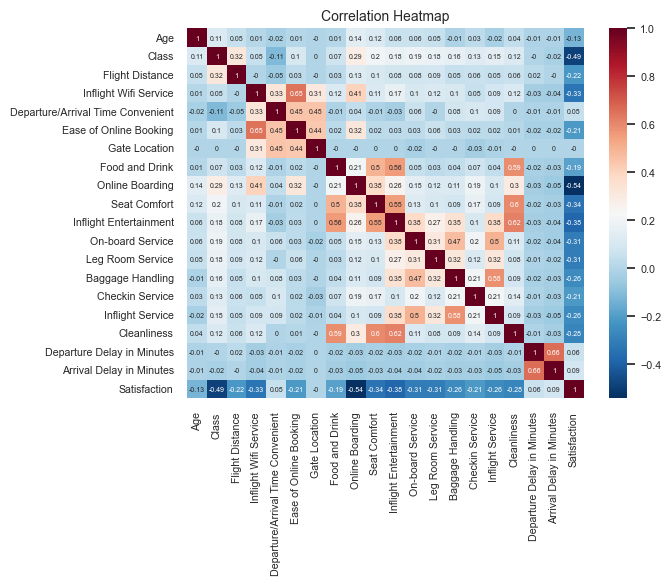

In [384]:
# Plotting the correlation heatmap:
sns.set(font_scale = 0.7)
ax = plt.axes()
rdbu_map= plt.get_cmap('RdBu')
reversed_map = rdbu_map.reversed()
sns.heatmap(round(train_corr_cat.corr(method = 'kendall'), 2), annot = True, cmap = reversed_map, annot_kws = {'size': 5}, ax = ax)
ax.set_title('Correlation Heatmap', fontsize = 10)
plt.show()

The correlation heatmap clearly shows that there are groups of features which are positively correlated amongst eachother. For example, `Food and Drink` is positively correlated to `Seat Comfort` and `Inflight Entertainment`, the latter two are also positively correlated amongst eachother. Not one feature is positively correlated with the response, `Satisfaction`. However, `Class` and `Online Boarding` are quite strongly negatively correlated with the response. Other variables negatively correlated with `Satisfaction` include `Inflight Wifi Service`, `Seat Comfort`, `On-board Service`, and `Leg Room Service`. When dealing with correlation, it is always important to remember that correlation does not imply causation. That is, even if a feature is correlated with the response, it does not mean that this feature causes the response outcome. In the case of positive correlation, it simply means that when a feature increases, the response also increase. 

Since it was not possible to include the nominal categorical variables `Gender`, `Customer Type`, and `Type of Travel` into the correlation heatmap, a Chi-Square Test for independence will be performed on each combination of the variables (including the response). This is done to check whether a relationship exists among these variables.

## Chi-Squared Test for Independence

The chi-square, ($\chi^2$), test for independence is a non-parametric hypothesis test, which tests whether two categorical variables are related to eachother. It can be performed on binary, ordinal and nominal data types. In this case, the three variables of interest are nominal and the response  is binary (and can even be considered ordinal). The null and alternative hypotheses are defined as follows:

**$H_0$: there is no association between the two variables tested. </br>
$H_1$: there is an association between the two variables tested, that is, the two variables are related.** (Ref 3) 

In [385]:
# Defining a function to perform chi-squared tests of association:
def chi_square_test(contingency_table):
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    print(f'Test results for the variables {contingency_table.index.names[0]} and {contingency_table.columns.names[0]}:')
    print(f'chi2_statistic: {round(chi2_stat, 2)}')
    print(f'p-value: {round(p_val, 2)}')

In [386]:
# Creating the first contingency table:
contingency_table_1 = pd.crosstab(train['Gender'], train['Customer Type'], margins = True)

# Applying the chi-squared test function:
chi_square_test(contingency_table_1)

Test results for the variables Gender and Customer Type:
chi2_statistic: 94.48
p-value: 0.0


The p-value is less than 0.05, therefore, the null hypothesis can be rejected at the 5% level of significance. The test suggests that there is an association between `Gender` and `Customer Type`.

In [387]:
# Creating the second contingency table:
contingency_table_2 = pd.crosstab(train['Gender'], train['Type of Travel'], margins = True)

# Applying the chi-squared test function:
chi_square_test(contingency_table_2)

Test results for the variables Gender and Type of Travel:
chi2_statistic: 4.52
p-value: 0.34


The p-value is more than 0.05, therefore, the null hypothesis can not be rejected at the 5% level of significance. The test suggests that there is no association between `Gender` and `Type of Travel`.

In [388]:
# Creating the third contingency table:
contingency_table_3 = pd.crosstab(train['Customer Type'], train['Type of Travel'])

# Applying the chi-squared test function:
chi_square_test(contingency_table_3)

Test results for the variables Customer Type and Type of Travel:
chi2_statistic: 9187.67
p-value: 0.0


The p-value is less than 0.05, therefore, the null hypothesis can be rejected at the 5% level of significance. The test suggests that there is an association between `Customer Type` and `Type of Travel`.

In [389]:
# Creating the fourth contingency table:
contingency_table_4 = pd.crosstab(train['Satisfaction'], train['Type of Travel'])

# Applying the chi-squared test function:
chi_square_test(contingency_table_4)

Test results for the variables Satisfaction and Type of Travel:
chi2_statistic: 20428.42
p-value: 0.0


The p-value is less than 0.05, therefore, the null hypothesis can be rejected at the 5% level of significance. The test suggests that there is an association between `Satisfaction` and `Type of Travel`. That is, customers on business trips are more likely to be satisfied than those traveling for personal reasons.

In [390]:
# Creating the fifth contingency table:
contingency_table_5 = pd.crosstab(train['Satisfaction'], train['Customer Type'])

# Applying the chi-squared test function:
chi_square_test(contingency_table_5)

Test results for the variables Satisfaction and Customer Type:
chi2_statistic: 4123.27
p-value: 0.0


The p-value is less than 0.05, therefore, the null hypothesis can be rejected at the 5% level of significance. The test suggests that there is an association between `Satisfaction` and `Customer Type`. Although, the test does not explicitly state which customers are more likely to be satisfied, it can be deduced that loyal customers are more likely to be satisfied than disloyal customers.

In [391]:
# Creating the sixth contingency table:
contingency_table_6 = pd.crosstab(train['Satisfaction'], train['Gender'])

# Applying the chi-squared test function:
chi_square_test(contingency_table_6)

Test results for the variables Satisfaction and Gender:
chi2_statistic: 18.38
p-value: 0.0


The p-value is less than 0.05, therefore, the null hypothesis can be rejected at the 5% level of significance. The test suggests that there is an association between `Satisfaction` and `Gender`. It is not clear which gender is more likely to be satisfied. 

## Count Plots

Count plots are presented to get further insights into the relationship of the ordinal variables and the response `Satisfaction`. Only the six most strongly correlated variables are included into the analysis. Count plots are simple visuals depicting the count of observations in each category of the variable of interest. Here, the plots have been separated into groups of 'satisfied' and 'neutral or dissatisfied' customers. 

In [392]:
# Importing the preprocessed data to ensure 'Satisfaction' is encoded nominally:
train = pd.read_pickle('../Data/Preprocessed_1/train_preprocessed_1.pkl')
test = pd.read_pickle('../Data/Preprocessed_1/test_preprocessed_1.pkl')

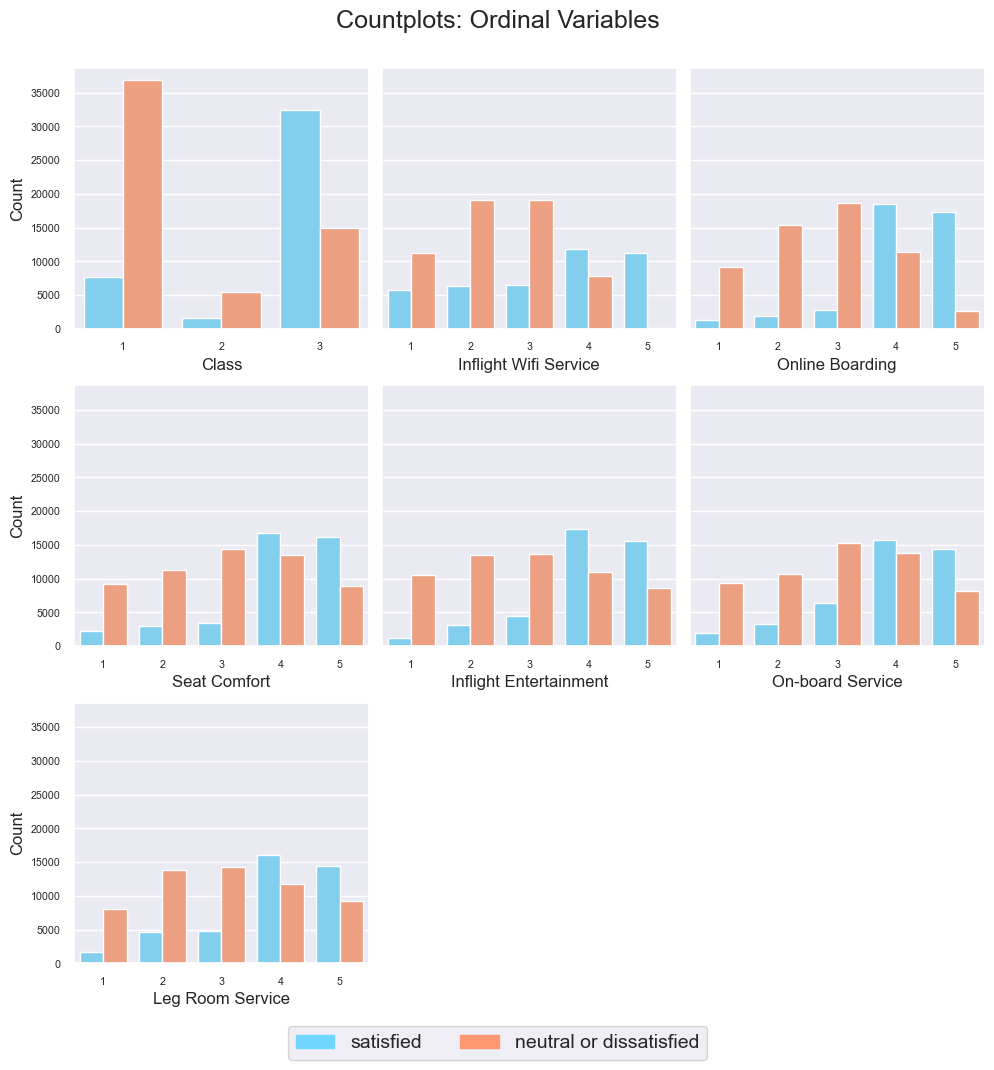

In [393]:
# Setting the palette dictionary:
hue_colors = {'neutral or dissatisfied': '#FF9770',
              'satisfied': '#70D6FF'}

# Defining the grid dimension and size of the plot:
fig, ax = plt.subplots(3, 3, sharey = True, figsize = (10, 10))

# Plotting the ordinal variables:
sns.countplot(ax = ax[0, 0], x = 'Class', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[0, 0].set_xlabel('Class', fontsize = 12)
ax[0, 0].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[0, 1], x = 'Inflight Wifi Service', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[0, 1].set_xlabel('Inflight Wifi Service', fontsize = 12)
ax[0, 1].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[0, 2], x = 'Online Boarding', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[0, 2].set_xlabel('Online Boarding', fontsize = 12)
ax[0, 2].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[1, 0], x = 'Seat Comfort', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[1, 0].set_xlabel('Seat Comfort', fontsize = 12)
ax[1, 0].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[1, 1], x = 'Inflight Entertainment', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[1, 1].set_xlabel('Inflight Entertainment', fontsize = 12)
ax[1, 1].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[1, 2], x = 'On-board Service', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[1, 2].set_xlabel('On-board Service', fontsize = 12)
ax[1, 2].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[2, 0], x = 'Leg Room Service', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[2, 0].set_xlabel('Leg Room Service', fontsize = 12)
ax[2, 0].set_ylabel('Count', fontsize = 12)

# Remove empty subplots
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])

# Creating the legend:
legend_labels = ['satisfied', 'neutral or dissatisfied']
legend_handles = [Patch(color=hue_colors[label], label=label) for label in legend_labels]
fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize = 14)

# Setting the title and other visual parameters:
plt.suptitle('Countplots: Ordinal Variables', fontsize = 18, y = 1.01)
plt.tight_layout()
plt.show()



In the `Class` subplot, the categories are `1`, `2`, and `3`, which corresponding to the Economy, Economy Plus and Business, respectively. It can be seen that there are many dissatisfied passengers in Economy (class 1). Conversly, there are many satisfied people in Business. By inspecting the other six plots, it can be seen that they all share a similar pattern. The dissatisfied passengers are distributed in a bell-shaped form across the 5 categories, while most satisfied customers appear in the 4th and 5th categories. These most likely correspond to the Business class services. 

## References

1. Learn Statistics Easily. *Kendall Tau-b vs Spearman: Which Correlation Coefficient Wins?* https://statisticseasily.com/kendall-tau-b-vs-spearman/#, Jan 4 2024. 

2. https://support.minitab.com/en-us/minitab/help-and-how-to/statistics/tables/supporting-topics/other-statistics-and-tests/what-are-concordant-and-discordant-pairs/

3. https://www.scribbr.com/statistics/chi-square-test-of-independence/#:~:text=A%20chi%2Dsquare%20test%20of%20independence%20works%20by%20comparing%20the,values%20of%20the%20other%20variable.&text=Example%3A%20Expected%20values%20The%20city,frequencies%20using%20the%20contingency%20table.